# Demographics

In [16]:
#imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set project root
import os
os.chdir('../..')

In [3]:
# Important! Set project root as current working directory first
from src.utils import get_project_root

root = get_project_root()
os.chdir(root)

In [4]:
index_col='answer_id'
date_cols=['sensordata_collected_at']

# Define a custom parser function for Unix timestamps
date_parser = lambda x: pd.to_datetime(float(x), unit='s')

# read in Baseline
bl = pd.read_csv('data/d01_raw/rki_heart_baseline.csv', index_col=index_col)

# read in FollowUp
fu = pd.read_csv('data/d01_raw/rki_heart_followup.csv', index_col=index_col)

## General facts about the datasets
### Baseline

In [5]:
print('Number of users and columns:\t', bl.shape)

Number of users and columns:	 (1805, 88)


## Distribution of demographics

### Age


In [6]:
bins = [10, 14, 17, 30, 40, 50, 60, 70, 80, 90, 120]
bl['age_decades'] = pd.cut(bl.alter, bins=bins)
res = pd.crosstab(bl.age_decades, bl.geschlecht)
res.to_csv('results/tables/age-by_sex.csv')
res

geschlecht,0.0,1.0,2.0
age_decades,,,
"(17, 30]",141,45,1
"(30, 40]",109,49,0
"(40, 50]",81,48,1
"(50, 60]",75,55,1
"(60, 70]",23,39,0
"(70, 80]",4,9,0
"(80, 90]",0,1,0
"(90, 120]",0,2,0


## Country

In [7]:
bl.country.value_counts()

country
DEU    675
AUT      3
MEX      1
GBR      1
AND      1
NLD      1
FRA      1
ATG      1
Name: count, dtype: int64

In [8]:
bl.country.value_counts(normalize=True)

country
DEU    0.986842
AUT    0.004386
MEX    0.001462
GBR    0.001462
AND    0.001462
NLD    0.001462
FRA    0.001462
ATG    0.001462
Name: proportion, dtype: float64

## FollowUp behaviour

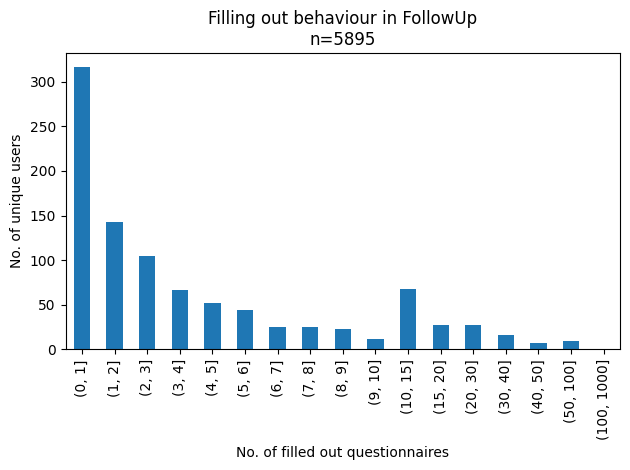

In [32]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,15, 20, 30, 40, 50, 100, 1000]
user_cnt = fu.user_id.value_counts()
pd.cut(user_cnt, bins).value_counts().sort_index().plot(kind='bar')

# Adding title and labels
plt.title('Filling out behaviour in FollowUp\nn=5895')
plt.xlabel('No. of filled out questionnaires')
plt.ylabel('No. of unique users')

plt.tight_layout()

plt.savefig('results/figures/filling_out_behaviour.svg')
# Display the plot
plt.show()

## When did users join the study?

Number of monthly active users in baseline


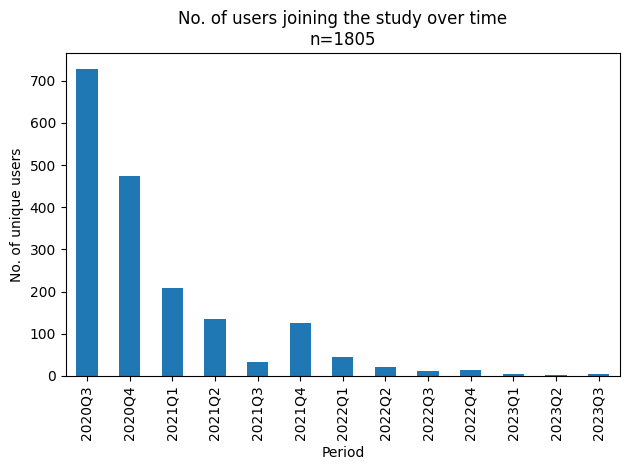

In [33]:
print('Number of monthly active users in baseline')
bl.created_at = pd.to_datetime(bl.created_at)
bl['YYYY-MM'] = bl.created_at.dt.strftime('%Y-%m')
bl['Q'] = bl.created_at.dt.to_period('Q')
bl.groupby('Q').nunique()['user_id'].plot(kind='bar')

# Adding title and labels
plt.title('No. of users joining the study over time\nn=1805')
plt.xlabel('Period')
plt.ylabel('No. of unique users')

plt.tight_layout()

plt.savefig('results/figures/users_joining_periods.svg')
# Display the plot
plt.show()